In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from source import data_import
from source.calculate_mean_psd import calculate_mean_psd
from source.constants import CHANNELS, FREQUENCY_RANGES

print(f"loaded channel names: {CHANNELS}")

loaded channel names: ['F4-C4', 'F3-C3', 'FT9-FT10', 'FZ-CZ', 'F7-T7', 'FP2-F4', 'T8-P8-1', 'T8-P8-0', 'FP1-F3', 'CZ-PZ']


In [24]:
# load data
df_pp = data_import.load_pyarrow(file_name="preprocessed_seg")
df_pp.shape

/Users/anabroggini/Documents/bootcamp/ai2/source/../data/preprocessed_seg.arrow was loaded.


(2956800, 17)

In [145]:
# df_pp = df_pp.iloc[:2_000_000,:]
# df_pp.shape

## Feature Extraction

In [25]:
# ignore for aggregation
ignore_col = []

# target definition
PRED_INTERVAL = 60
target_colname = 'target'

In [26]:
### aggregate Functions for mean psd:
delta = lambda x: calculate_mean_psd(x, frequency_ranges={'Delta' : FREQUENCY_RANGES['Delta']})[x.name]['Delta']
theta = lambda x: calculate_mean_psd(x, frequency_ranges={'Theta' : FREQUENCY_RANGES['Theta']})[x.name]['Theta']
gamma = lambda x: calculate_mean_psd(x, frequency_ranges={'Gamma': FREQUENCY_RANGES['Gamma']})[x.name]['Gamma']

delta_agg = pd.NamedAgg(column='delta', aggfunc=delta)
theta_agg = pd.NamedAgg(column='theta', aggfunc=theta)
gamma_agg = pd.NamedAgg(column='gamma', aggfunc=gamma)

### aggregate Functions for target:
target_foo = lambda x, pred_interval=PRED_INTERVAL: 0 < x.dt.total_seconds().min() < pred_interval


In [27]:
abs_mean = lambda x: x.apply(abs).mean()
abs_mean_agg = pd.NamedAgg(column='abs_mean', aggfunc=abs_mean)

In [28]:
df_features = df_pp.groupby(['epoch', 'segment_id']).agg(
    {C:[
        # 'mean', 
        'std',
        'var',
        'mean',
        abs_mean_agg,
        delta_agg,
        theta_agg,
        gamma_agg
        ] for C in CHANNELS} | 
    {target_colname: [target_foo]} 
    ) 
df_features.head()

channel               F4-C4                                               \
                        std         var      mean   abs_mean       delta   
epoch segment_id                                                           
0     0           19.215291  369.227396  1.677760  14.539727   39.509423   
      1           19.292719  372.208995 -0.391839  15.081409   57.166882   
      2           26.026211  677.363658  1.356797  18.727514  112.603482   
      3           26.999490  728.972443 -1.657887  18.877600  148.551723   
      4           23.273241  541.643731  0.776272  17.412866   77.372989   

channel                                    F3-C3                        ...  \
                      theta     gamma        std         var      mean  ...   
epoch segment_id                                                        ...   
0     0           15.649456  1.143016  21.315638  454.356435  1.053339  ...   
      1           13.481116  1.218430  25.477037  649.079429  0.811962  ...   
      2           22.111449  0.943441  27.729263  768.912015  1.282874  ...   
      3           15.161321  1.178056  29.614908  877.042781 -2.174102  ...   
      4           25.561364  1.423834  23.413506  548.192254  0.848064  ...   

channel               FP1-F3                 CZ-PZ                        \
                       theta      gamma        std         var      mean   
epoch segment_id                                                           
0     0            92.822474  22.441816  16.368013  267.911860  0.692305   
      1            76.808250  33.427544  18.012047  324.433840 -0.487618   
      2           176.024973   8.914849  22.813508  520.456131  1.294472   
      3            75.730101  21.215121  19.942794  397.715029 -0.476040   
      4           284.475569  16.303152  18.725786  350.655046  1.382429   

channel                                                       target  
                   abs_mean      delta      theta     gamma <lambda>  
epoch segment_id                                                      
0     0           13.053429  33.181709  18.606278  0.272641    False  
      1           14.154003  40.078259  21.722061  0.268936    False  
      2           18.522101  78.066994  19.695134  0.256728    False  
      3           15.324033  60.340596  18.821070  0.258679    False  
      4           15.186356  46.083693  24.182717  0.271254    False  

[5 rows x 71 columns]

## Flatten Dataframe

In [29]:
# joining column names with agg functions, but leaving target column
df_features.columns = ['_'.join(col).strip() for col in df_features.columns.values if target_colname != col[0]] + [target_colname]
df_features.reset_index(inplace=True)
df_features.head(10)


,epoch,segment_id,F4-C4_std,F4-C4_var,F4-C4_mean,F4-C4_abs_mean,F4-C4_delta,F4-C4_theta,F4-C4_gamma,F3-C3_std,...,FP1-F3_theta,FP1-F3_gamma,CZ-PZ_std,CZ-PZ_var,CZ-PZ_mean,CZ-PZ_abs_mean,CZ-PZ_delta,CZ-PZ_theta,CZ-PZ_gamma,target
0,0,0,19.215291,369.227396,1.677760,14.539727,39.509423,15.649456,1.143016,21.315638,...,92.822474,22.441816,16.368013,267.911860,0.692305,13.053429,33.181709,18.606278,0.272641,False
1,0,1,19.292719,372.208995,-0.391839,15.081409,57.166882,13.481116,1.218430,25.477037,...,76.808250,33.427544,18.012047,324.433840,-0.487618,14.154003,40.078259,21.722061,0.268936,False
2,0,2,26.026211,677.363658,1.356797,18.727514,112.603482,22.111449,0.943441,27.729263,...,176.024973,8.914849,22.813508,520.456131,1.294472,18.522101,78.066994,19.695134,0.256728,False
3,0,3,26.999490,728.972443,-1.657887,18.877600,148.551723,15.161321,1.178056,29.614908,...,75.730101,21.215121,19.942794,397.715029,-0.476040,15.324033,60.340596,18.821070,0.258679,False
4,0,4,23.273241,541.643731,0.776272,17.412866,77.372989,25.561364,1.423834,23.413506,...,284.475569,16.303152,18.725786,350.655046,1.382429,15.186356,46.083693,24.182717,0.271254,False
5,0,5,22.655431,513.268557,-0.036669,16.969776,76.212479,24.818786,1.681127,27.859298,...,249.780076,36.113652,19.742360,389.760781,-0.752261,15.359382,47.760727,27.818370,0.314380,False
6,0,6,23.433931,549.149139,0.828300,17.152483,76.743032,11.805732,0.505023,25.189341,...,71.469402,5.602255,19.722776,388.987881,-1.199098,15.671624,70.917918,21.647252,0.286571,False
7,0,7,18.370345,337.469568,0.423259,14.567939,48.173382,16.238093,0.567528,20.170082,...,11.973851,11.339858,17.475646,305.398194,1.369375,14.012370,41.424539,19.537928,0.229929,False
8,0,8,21.013780,441.578959,-0.204437,16.212443,65.756756,19.679089,0.560435,20.608746,...,123.848518,11.259756,19.824534,393.012134,-0.127999,15.558344,44.656950,22.937501,0.205348,False
9,0,9,20.651241,426.473748,-0.541733,14.850569,63.858712,22.948710,0.843431,25.653559,...,165.497411,13.510767,19.307319,372.772585,0.023715,15.797946,53.685350,20.680972,0.175309,False


In [56]:
#Preparing data to be scaled

num_features= df_features.drop(['epoch','segment_id','target'],axis =1)

from sklearn.preprocessing import StandardScaler, minmax_scale, MinMaxScaler

scaler = StandardScaler()
num_features_scaled = scaler.fit_transform(num_features)

/Users/anabroggini/Documents/bootcamp/ai2/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/anabroggini/Documents/bootcamp/ai2/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/anabroggini/Documents/bootcamp/ai2/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/anabroggini/Documents/bootcamp/ai2/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:767

In [57]:
original_array =np.array(df_features)
target=original_array[:,-1]
target = target[:, np.newaxis]
segseiz_column = original_array[:, 0:2] ## epoch and segment_id
array_all_scaled = np.concatenate((segseiz_column, num_features_scaled, target), axis=1)
array_all_scaled.shape

(2310, 73)

In [58]:
# Determine the number of epochs
num_epochs = df_features.epoch.nunique()
# # Determine the number of segments for each epoch
num_segments = df_features.segment_id.nunique()  # Assuming there are 30 segments for each epocha
num_features = array_all_scaled.shape[1]

reshaped_all= array_all_scaled.reshape(num_epochs, num_segments, num_features)
reshaped_all.shape

(77, 30, 73)

In [42]:
# import numpy as np


# original_array =np.array(df_features)

# # Extract the epoch column
# epoch_column = original_array[:, 0]

# # Determine the number of epochs (assuming epochs are from 1 to number of segments)
# num_epochs = df_features.epoch.unique()[-1]

# # Determine the number of segments for each epoch
# num_segments = len(df_features.segment_id.unique())  # Assuming there are 30 segments for each epoch

# # Initialize an empty 3D array
# reshaped_array = np.empty((num_epochs,num_segments, array_all_scaled.shape[1]))

# # Reshape the data for each epoch and insert it into the 3D array
# for epoch in range(num_epochs):
#     start_idx = epoch * num_segments
#     end_idx = (epoch + 1) * num_segments
#     reshaped_array[epoch,:, :] = array_all_scaled[start_idx:end_idx,:]

In [43]:
reshaped_array.shape

(76, 30, 73)

In [59]:
data =reshaped_all[50,:,2:]

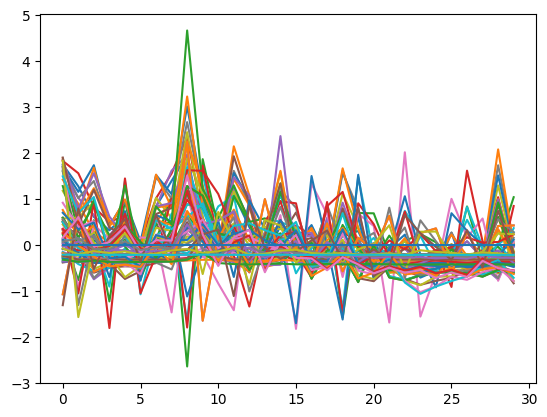

In [60]:
plt.plot(data)

In [62]:

np.save('data/feature_extract_reshaped.npy', reshaped_all)

In [26]:
# from source.data_import import save_pyarrow

# save_pyarrow(df_features, file_name="feature_extracted")

/Users/anabroggini/Documents/bootcamp/ai2/source/../data/feature_extracted.arrow was successfully written.
